In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay, mean_squared_error, r2_score, mean_absolute_error

In [2]:
#Configurar el dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Definir transformaciones para las imágenes (normalización + tamaño igual para todas)
transformaciones=transforms.Compose([
    transforms.Resize((128,128)),                        #Redimensionar todas las imágenes a (128x128) píxeles
    transforms.ToTensor(),                               #Convertir la imagen a tensor
    #transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))   #Normalizar los valores RGB entre -1 y 1
])

In [3]:
#Cargar las imágenes usando ImageFolder, que asigna automáticamente las etiquetas
ruta_datos = "BaseDatos_Caras"
dataset = datasets.ImageFolder(root = ruta_datos, transform = transformaciones)

#Mostrar qué clase es qué número
print("Clases asignadas:",dataset.class_to_idx)

Clases asignadas: {'caras_falsas': 0, 'caras_reales': 1}


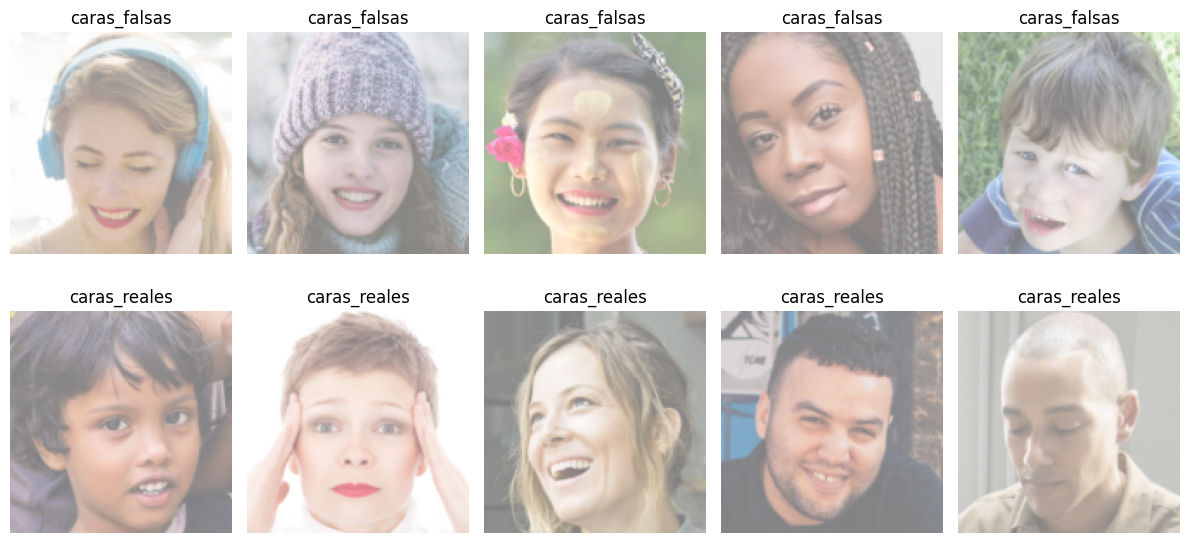

In [4]:
#Crear diccionario para indexar clases
idx_a_clase={v:k for k,v in dataset.class_to_idx.items()}

#Crear figura para mostrar imágenes
fig,axs=plt.subplots(2,5,figsize=(12,6))        #2 clases, 5 imágenes por clase
clases_mostradas={0:0,1:0}                      #Contador por clase

for imagen,etiqueta in dataset:
    if clases_mostradas[etiqueta]<5:
        i=etiqueta
        j=clases_mostradas[etiqueta]
        img=imagen.permute(1,2,0)*0.5+0.5    #Desnormalizar
        axs[i,j].imshow(img.numpy())
        axs[i,j].axis('off')
        axs[i,j].set_title(f"{idx_a_clase[etiqueta]}")
        clases_mostradas[etiqueta]+=1
    if all([v==5 for v in clases_mostradas.values()]): #Parar con 5 de cada
        break

plt.tight_layout()
plt.show()

In [5]:
#Dividir el dataset en entrenamiento y validación
train_size = int(0.8 * len(dataset)) #80% entrenamiento
val_size = len(dataset) - train_size   #20% validación
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#Crear los loaders que permiten cargar los datos por lotes
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

In [6]:
print(len(train_dataset))
#1081 reales
#1741 falsos
#la suma es 2822

2257


In [7]:
#Definición del modelo CNN mejorada
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128*32*32, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        x = x.view(-1, 128*32*32)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [8]:
#Instanciar la red y la llevamos al dispositivo (GPU/CPU)
modelo=CNN().to(device)

#Hiperparámetros
NUM_MODELOS = 10
NUM_EPOCHS = 10
BATCH_SIZE = 32
MIN_ACCURACY = 0.83
LEARNING_RATE = 0.001

#Definir la función de pérdida (CrossEntropy porque es clasificación) y el optimizador (Adam)
#Queremos penalizar más si falla en detectar caras falsas → peso mayor para clase 1
pesos = torch.tensor([3.0, 2.0])  #Aumenta el peso de la clase falsa
criterio = nn.CrossEntropyLoss(weight=pesos.to(device))

#Si usas CrossEntropyLoss, puedes añadir weight para penalizar más los errores en la clase minoritaria:
optimizador=optim.Adam(modelo.parameters(), lr=0.001, weight_decay=1e-4)

#Inicializar listas para guardar las pérdidas de entrenamiento y validación
train_losses = []  #Lista para almacenar la pérdida promedio de entrenamiento por época
val_losses = [] 


#--> Variables para el mejor modelo
best_val_loss = float('inf')  #--> pérdida más baja observada
best_model_state = None       #--> para guardar los pesos del mejor modelo

#Entrenamiento del modelo
num_epocas = 10
for epoca in range(num_epocas):
    modelo.train()
    train_loss = 0
    
    for imagenes,etiquetas in train_loader:
        imagenes,etiquetas=imagenes.to(device),etiquetas.to(device)
        optimizador.zero_grad()                     #Reiniciar gradientes
        salida=modelo(imagenes)                     #Paso hacia adelante
        perdida=criterio(salida,etiquetas)          #Calcular pérdida
        perdida.backward()                          #Retropropagación
        optimizador.step()                          #Ajustar pesos
        train_loss +=perdida.item()
        
    #Promediar el train loss por batch
    train_loss /= len(train_loader)
    train_losses.append(train_loss)  #Almacenar el train loss

    # Validación
    modelo.eval()
    val_loss = 0.0
    todas_predicciones = []
    todas_etiquetas = []
               
    with torch.no_grad():
        for imagenes, etiquetas in val_loader:
            imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
            salidas = modelo(imagenes)
            perdida_val = criterio(salidas, etiquetas)
            val_loss += perdida_val.item()

            _, predicciones = torch.max(salidas, 1)
            todas_predicciones.extend(predicciones.cpu().numpy())
            todas_etiquetas.extend(etiquetas.cpu().numpy())     

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
        
    #Guardar el modelo si mejora la pérdida de validación
    if val_loss<best_val_loss:
        best_val_loss=val_loss                       #Actualizar mejor pérdida
        best_model_state=modelo.state_dict()         #Guardar pesos del mejor modelo
        print(f"Mejor modelo actualizado en epoch {epoca} con val_loss={val_loss:.4f}")

    #Imprimir métricas
        
    #Imprimir el train loss y el val loss cada epoca
    print(f"Epoch {epoca}/{num_epocas}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

#Guardar el mejor modelo tras el entrenamiento
if best_model_state is not None:
    modelo.load_state_dict(best_model_state)              #Cargar mejor modelo
    torch.save(modelo.state_dict(),"mejor_modelo_cnn.pth")  
    print("Mejor modelo guardado como mejor_modelo_cnn.pth")


Mejor modelo actualizado en epoch 0 con val_loss=0.4125
Epoch 0/10, Train Loss: 4.1137, Val Loss: 0.4125
Mejor modelo actualizado en epoch 1 con val_loss=0.3876
Epoch 1/10, Train Loss: 0.4174, Val Loss: 0.3876
Mejor modelo actualizado en epoch 2 con val_loss=0.3833
Epoch 2/10, Train Loss: 0.4015, Val Loss: 0.3833
Mejor modelo actualizado en epoch 3 con val_loss=0.3424
Epoch 3/10, Train Loss: 0.3745, Val Loss: 0.3424
Epoch 4/10, Train Loss: 0.3598, Val Loss: 0.3538
Epoch 5/10, Train Loss: 0.3528, Val Loss: 0.3516
Epoch 6/10, Train Loss: 0.3332, Val Loss: 0.3514
Epoch 7/10, Train Loss: 0.3300, Val Loss: 0.3495
Epoch 8/10, Train Loss: 0.3061, Val Loss: 0.3490
Mejor modelo actualizado en epoch 9 con val_loss=0.3207
Epoch 9/10, Train Loss: 0.3067, Val Loss: 0.3207
Mejor modelo guardado como mejor_modelo_cnn.pth


In [9]:
#Evaluación del modelo
modelo.eval()
todas_predicciones=[]
todas_etiquetas=[]

test_loss = 0.0  #Variable para acumular la pérdida total en el conjunto de validación


with torch.no_grad():
    for imagenes,etiquetas in val_loader:
        imagenes=imagenes.to(device)
        etiquetas=etiquetas.to(device)  #Mover las etiquetas también al dispositivo
        salidas=modelo(imagenes)
        
        test_loss += criterio(salidas,etiquetas).item()  #Calcular la pérdida para este lote
        
        
        _,predicciones=torch.max(salidas,1)
        todas_predicciones.extend(predicciones.cpu().numpy())
        todas_etiquetas.extend(etiquetas.numpy())

#Cálculo de la pérdida en el conjunto de validación
print(f"Test Loss: {test_loss:.4f}")
test_loss /= len(val_loader)

#mejor modelo: 0.83
#--> 33 falsos reales (positivos) 9%

#75% y 10 fr!!!  2%
#77% y 20 fr!!

#mejor modelo accuracy es 0.85 % pero 66 f r 
#80% y 29 n f

Test Loss: 5.7727


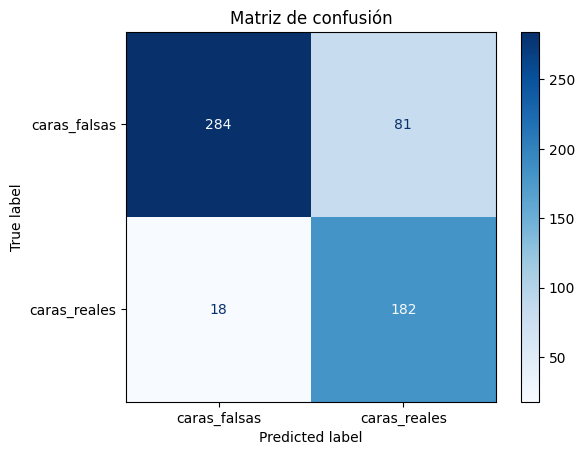

Reporte de clasificación:
               precision    recall  f1-score   support

caras_falsas       0.94      0.78      0.85       365
caras_reales       0.69      0.91      0.79       200

    accuracy                           0.82       565
   macro avg       0.82      0.84      0.82       565
weighted avg       0.85      0.82      0.83       565



In [10]:
#Matriz de confusión    
disp=ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(todas_etiquetas,todas_predicciones),display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.show()

#Reporte de métricas adicionales
reporte=classification_report(todas_etiquetas,todas_predicciones,target_names=dataset.classes)
print("Reporte de clasificación:\n",reporte)

### Gráfica de la Pérdida Durante el Entrenamiento

Una de las maneras más efectivas de visualizar el progreso del modelo es mediante la gráfica de la pérdida a lo largo de las épocas. Esta gráfica muestra cómo la pérdida de entrenamiento y la pérdida de validación cambian durante el proceso de entrenamiento.

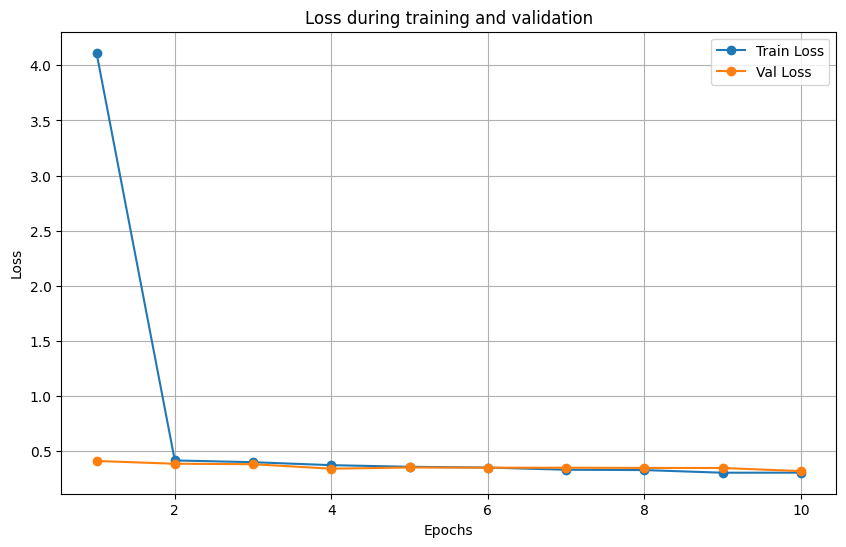

In [11]:
# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epocas+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epocas+1), val_losses, marker='o', label='Val Loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss during training and validation")
plt.legend()
plt.grid(True)
plt.show()

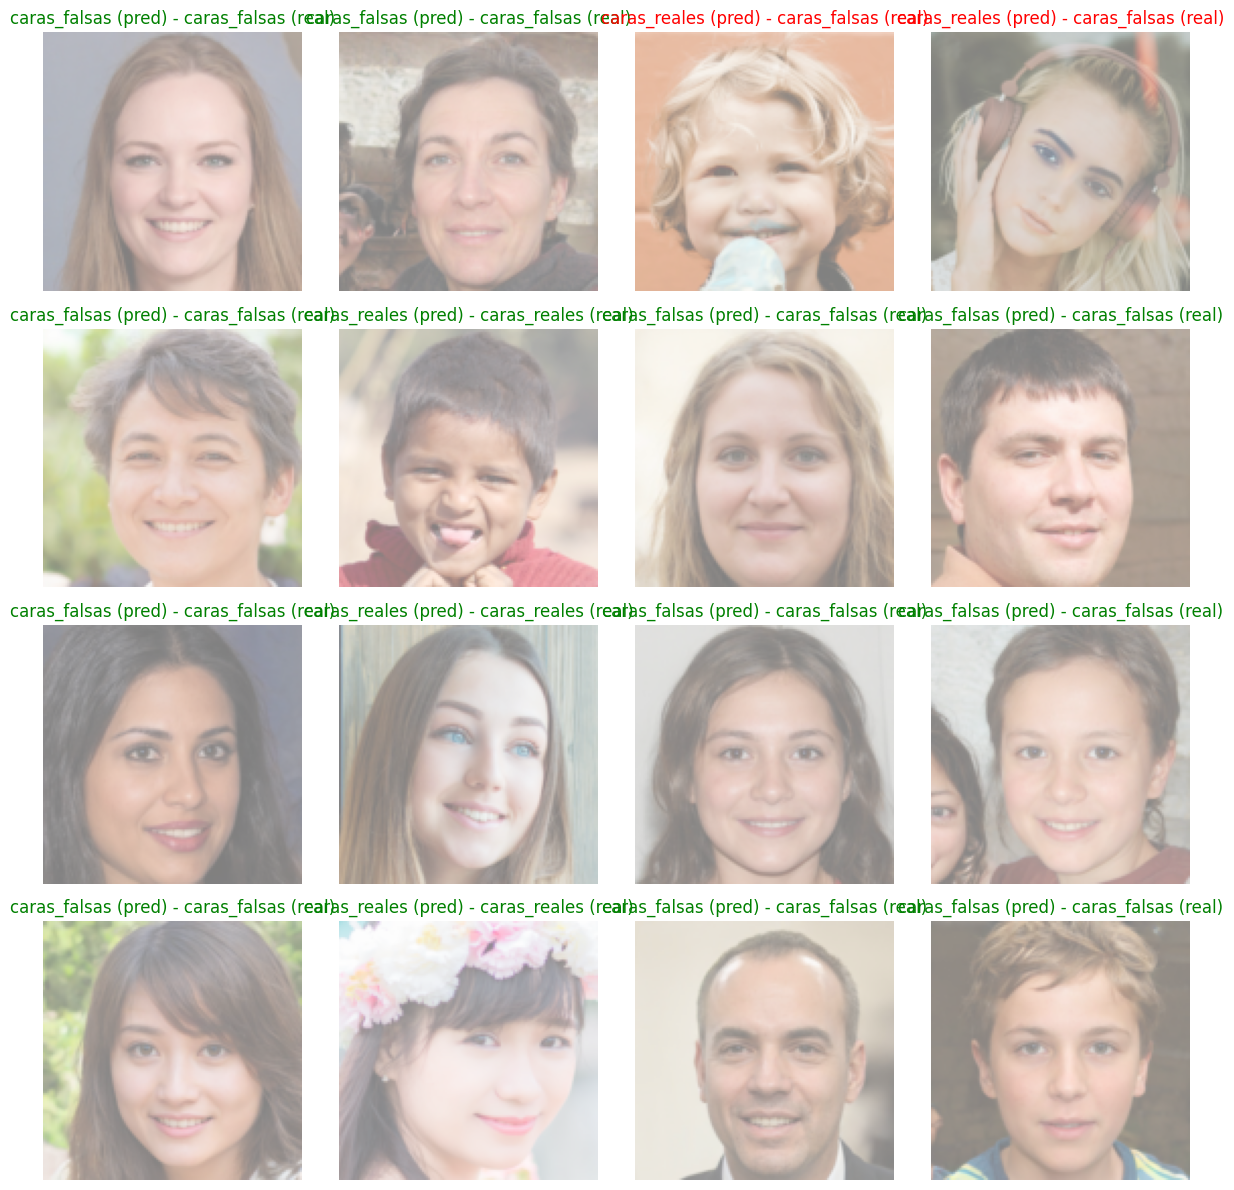

In [12]:
#meter tambien que devuelva la probabilidad con la que predice, si hay una con 51% de ser una cosa pues bueno falla, y con cuanto % predice sbs
###
###


#Diccionario para convertir índices a nombres de clase
idx_a_clase={v:k for k,v in dataset.class_to_idx.items()}

#Mostramos algunas predicciones del modelo en el conjunto de validación
fig,axs=plt.subplots(4,4,figsize=(12,12))#mostramos 16 imágenes
contador=0

with torch.no_grad():
    for imagenes,etiquetas in val_loader:
        imagenes=imagenes.to(device)
        salida=modelo(imagenes)
        probabilidades = F.softmax(salida, dim=1)  # Obtener probabilidad para cada clase
        _,preds=torch.max(salida,1)
        
        for i in range(imagenes.size(0)):
            if contador>=16:
                break
            
            imagen=imagenes[i].cpu().permute(1,2,0)#(C,H,W) → (H,W,C)
            imagen=imagen*0.5+0.5#desnormalizamos
            
            etiqueta_real = idx_a_clase[etiquetas[i].item()]
            predicha_idx = preds[i].item()
            etiqueta_predicha = idx_a_clase[predicha_idx]
            prob_predicha = probabilidades[i][predicha_idx].item() * 100  # En porcentaje
            
            color='green' if etiqueta_real==etiqueta_predicha else 'red'
            ax=axs[contador//4,contador%4]
            ax.imshow(imagen.numpy())
            ax.axis('off')
            ax.set_title(f"{etiqueta_predicha} (pred) - {etiqueta_real} (real)",color=color)
            
            contador+=1
            
        if contador>=16:
            break

plt.tight_layout()
plt.show()


C:\Users\hugof\AppData\Local\Temp\ipykernel_27976\2451539244.py:46: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


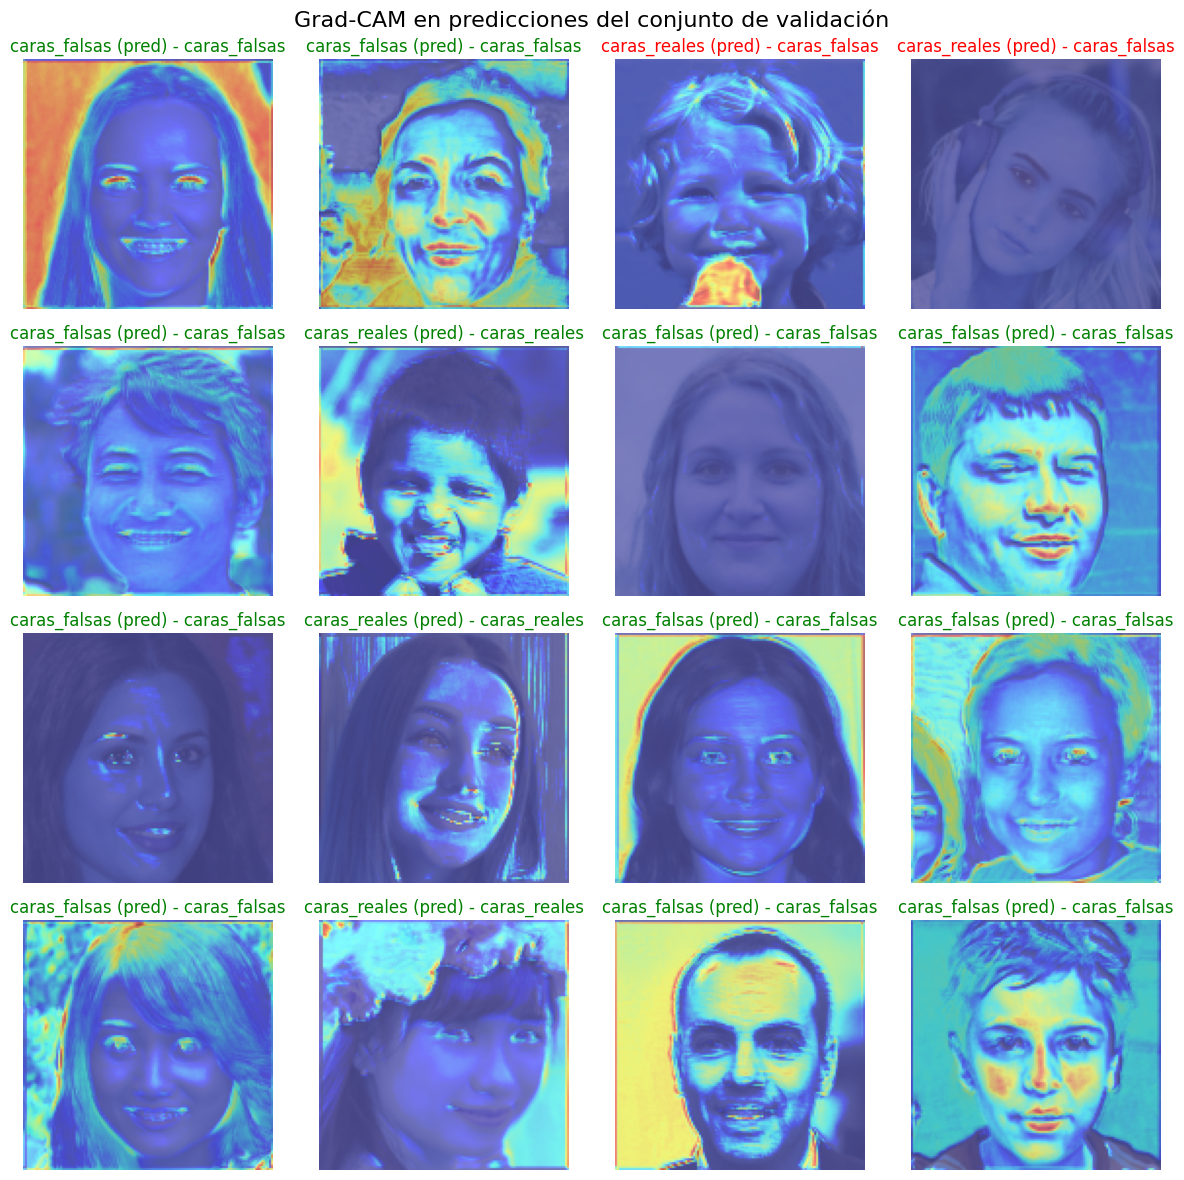

In [13]:
#Diccionario para convertir índices a nombres de clase
idx_a_clase = {v: k for k, v in dataset.class_to_idx.items()}

#--- Función Grad-CAM para un tensor individual (imagen del val_loader) ---
def aplicar_gradcam_tensor(modelo, imagen_tensor, transformaciones, clase_idx=None):
    modelo.eval()
    
    # Añadir dimensión batch y permitir gradiente
    imagen_tensor = imagen_tensor.unsqueeze(0).to(device).requires_grad_()

    activaciones = []

    # Hook para capturar la salida de la última capa convolucional
    def hook_func(module, input, output):
        activaciones.append(output)

    # Registramos el hook
    handle = modelo.conv2.register_forward_hook(hook_func)

    # Hacemos la predicción
    salida = modelo(imagen_tensor)
    if clase_idx is None:
        clase_idx = torch.argmax(salida)

    modelo.zero_grad()
    clase_score = salida[0, clase_idx]
    clase_score.backward()

    # Obtenemos el gradiente y activaciones
    grad = imagen_tensor.grad.squeeze(0).cpu().detach()
    activacion = activaciones[0].squeeze(0).cpu().detach()

    # Calculamos el mapa CAM
    pesos = torch.mean(grad, dim=(1, 2))
    cam = torch.zeros(activacion.shape[1:], dtype=torch.float32)
    for i, w in enumerate(pesos):
        cam += w * activacion[i]

    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()
    cam = cam.numpy()

    # Redimensionamos y coloreamos
    heatmap = cv2.resize(cam, (128, 128))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Imagen original para superponer (desnormalizada)
    imagen_np = imagen_tensor.squeeze(0).cpu().detach().permute(1, 2, 0).numpy()
    imagen_np = imagen_np * 0.5 + 0.5  # desnormalizar
    imagen_np = np.clip(imagen_np * 255, 0, 255).astype(np.uint8)

    # Superponer mapa de calor
    superpuesta = cv2.addWeighted(imagen_np, 0.5, heatmap_color, 0.5, 0)
    superpuesta = cv2.cvtColor(superpuesta, cv2.COLOR_BGR2RGB)

    handle.remove()
    return superpuesta

#--- Mostrar 16 imágenes del val_loader con su Grad-CAM ---
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
contador = 0

# Quitamos el with torch.no_grad() para que se puedan calcular gradientes
for imagenes, etiquetas in val_loader:
    imagenes = imagenes.to(device)
    salida = modelo(imagenes)
    _, preds = torch.max(salida, 1)

    for i in range(imagenes.size(0)):
        if contador >= 16:
            break

        imagen = imagenes[i].detach().cpu()
        etiqueta_real = idx_a_clase[etiquetas[i].item()]
        etiqueta_predicha = idx_a_clase[preds[i].item()]
        color = 'green' if etiqueta_real == etiqueta_predicha else 'red'

        # Aplicar Grad-CAM (sin gradiente desactivado)
        gradcam_img = aplicar_gradcam_tensor(modelo, imagen, transformaciones)

        ax = axs[contador // 4, contador % 4]
        ax.imshow(gradcam_img)
        ax.axis('off')
        ax.set_title(f"{etiqueta_predicha} (pred) - {etiqueta_real}", color=color)
        contador += 1

    if contador >= 16:
        break

plt.suptitle("Grad-CAM en predicciones del conjunto de validación", fontsize=16)
plt.tight_layout()
plt.show()


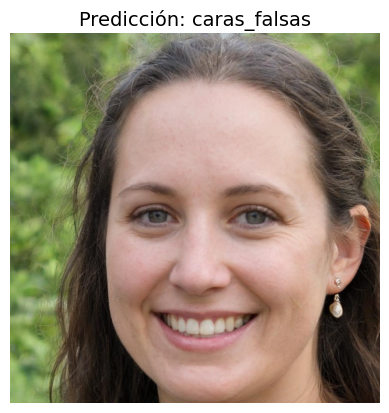

In [14]:
#Cargar imagen de prueba (pon el path de la imagen que quieras predecir)
ruta_imagen = "PruebaFalsa_1.jpeg"  # Reemplaza con la ruta de la imagen

#Cargar imagen original con OpenCV
imagen_cv2 = cv2.imread(ruta_imagen)
imagen_cv2_rgb = cv2.cvtColor(imagen_cv2, cv2.COLOR_BGR2RGB)

imagen_pil = Image.fromarray(imagen_cv2_rgb).convert("RGB")
imagen_transformada = transformaciones(imagen_pil).unsqueeze(0).to(device)

#Predecir con el modelo
modelo.eval()
with torch.no_grad():
    salida = modelo(imagen_transformada)
    _, prediccion = torch.max(salida, 1)

prediccion_imagen = dataset.classes[prediccion.item()]

#Mostrar imagen recortada con predicción
plt.imshow(imagen_pil)
plt.axis('off')
plt.title(f"Predicción: {prediccion_imagen}", fontsize=14)
plt.show()

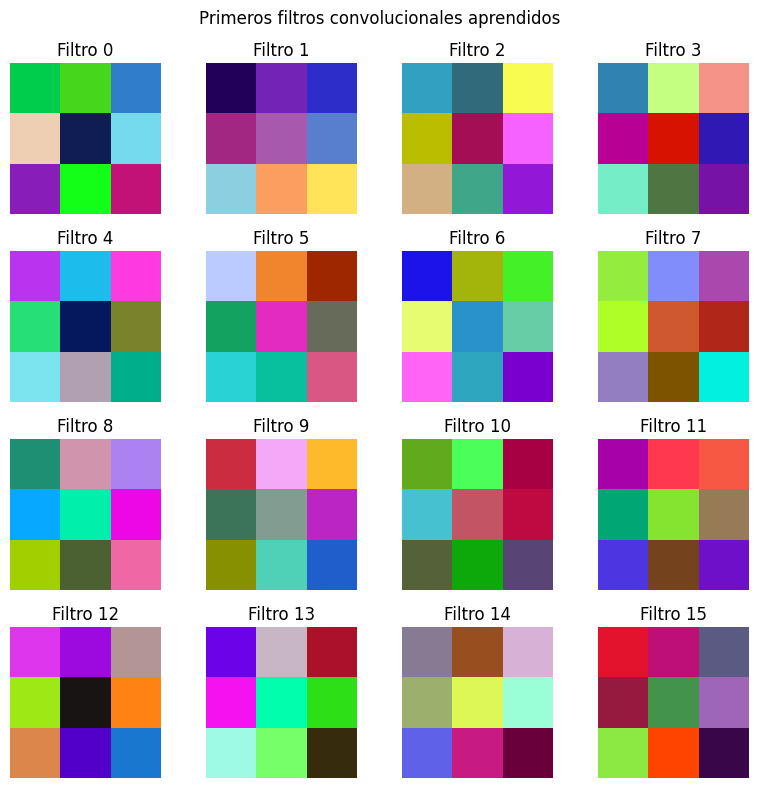

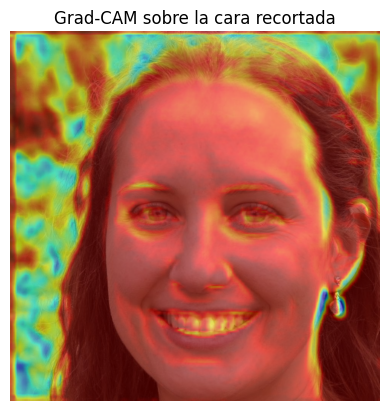

In [15]:
#Visualización de filtros
primer_capa = modelo.conv1
filtros = primer_capa.weight.data.clone().cpu()
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    filtro = filtros[i]
    filtro = filtro - filtro.min()
    filtro = filtro / filtro.max()
    filtro = np.transpose(filtro.numpy(), (1, 2, 0))
    axs[i // 4, i % 4].imshow(filtro)
    axs[i // 4, i % 4].axis('off')
    axs[i // 4, i % 4].set_title(f"Filtro {i}")
plt.suptitle("Primeros filtros convolucionales aprendidos")
plt.tight_layout()
plt.show()

#Grad-CAM
def aplicar_gradcam_imagen_pil(modelo, imagen_pil, transformaciones, clase_idx=None):
    modelo.eval()
    imagen_tensor = transformaciones(imagen_pil).unsqueeze(0).to(device).requires_grad_()

    activaciones = []
    def hook_func(module, input, output):
        activaciones.append(output)

    # Hook a la última capa convolucional (ajustar si cambias la arquitectura)
    handle = modelo.conv2.register_forward_hook(hook_func)

    salida = modelo(imagen_tensor)
    if clase_idx is None:
        clase_idx = torch.argmax(salida)

    modelo.zero_grad()
    clase_score = salida[0, clase_idx]
    clase_score.backward()

    grad = imagen_tensor.grad.squeeze(0).cpu().detach()
    activacion = activaciones[0].squeeze(0).cpu().detach()

    pesos = torch.mean(grad, dim=(1, 2))
    cam = torch.zeros(activacion.shape[1:], dtype=torch.float32)
    for i, w in enumerate(pesos):
        cam += w * activacion[i]

    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()
    cam = cam.numpy()

    heatmap = cv2.resize(cam, imagen_pil.size)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    imagen_np = np.array(imagen_pil)
    superpuesta = cv2.addWeighted(imagen_np, 0.5, heatmap_color, 0.5, 0)

    plt.imshow(superpuesta)
    plt.axis('off')
    plt.title("Grad-CAM sobre la cara recortada")
    plt.show()

    handle.remove()
    
    
#Aplicamos Grad-CAM a la imagen de prueba
aplicar_gradcam_imagen_pil(modelo, imagen_pil, transformaciones)
